In [9]:
# Step 1: Transceiver Initialisation
import ssh
import xcvr_control
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from numpy.fft import fft, fftshift, fftfreq

#ema_host = "ema-014254.local"
ema_host = "169.254.9.108"
passwords = {}

s = ssh.SSH(ema_host, passwords)
xcvr = xcvr_control.XcvrControl(ema_host)

def initialise():
    s.send_command("/usr/bin/killall xcvrtool")
    s.send_command("/run/media/mmcblk0p2/test/xcvrtool &") # Start transceiver tool in background
    s.send_command("/sbin/devmem 0x40014000 32 0x00") # Disable all PSUs
    s.send_command("/sbin/devmem 0x40014000 32 0xFF") # Enable all PSUs
    s.send_command("/sbin/devmem 0x40015008 32 0x01") # Enable clock generator
    s.send_command("cd /run/media/mmcblk0p2/test;/usr/bin/python3 ad9528.py") # Initialise clock generator
    s.send_command("cd /run/media/mmcblk0p2/test;/usr/bin/python3 timing_control.py -t") # Enable Rx test mode
    if xcvr.connect():
        return xcvr.initialise()
    else:
        return False

initialise()

Connected to 169.254.9.108


In [10]:
# Step 2: Function Declarations
location_name="k4" # Set this to a string representing the capture location

def capture(capture_size, filename):    
    s.send_command("/usr/bin/fallocate /run/media/nvme0n1/{} -l {}".format(filename, capture_size))
    s.send_command("/bin/echo 1 > /sys/kernel/kcema-driver/reset")
    s.send_command("/bin/echo 0 > /sys/kernel/kcema-driver/reset")
    s.send_command("/bin/echo /run/media/nvme0n1/{} > /sys/kernel/kcema-driver/write_path".format(filename))
    s.send_command("/bin/echo 1 > /sys/kernel/kcema-driver/write_state")

# Preselectors:
# 0: 400 MHz to 600 MHz
# 1: 600 MHz to 1000 MHz
# 2: 1000 MHz to 1400 MHz
# 3: 1400 MHz to 2200 MHz
# 4: 2200 MHz to 3000 MHz
# 5: 3000 MHz to 4600 MHz
# 6: 4600 MHz to 6000 MHz
# 7: Isolation

def preselector(centre_freq_Hz):
    if centre_freq_Hz <= 600e6:
        return 0
    elif centre_freq_Hz <= 1000e6:
        return 1
    elif centre_freq_Hz <= 1400e6:
        return 2
    elif centre_freq_Hz <= 2200e6:
        return 3
    elif centre_freq_Hz <= 3000e6:
        return 4
    elif centre_freq_Hz <= 4600e6:
        return 5
    elif centre_freq_Hz <= 6000e6:
        return 6
    else:
        return 7


In [37]:
# Step 3: Tune Receiver
centre_freq_MHz = 2150  # Set this: EMA captures fc ±50 MHz
fft_size = 65536        # Don't change
sample_rate = 122.88e6  # Don't change
centre_freq = centre_freq_MHz * 1e6
presel = preselector(centre_freq)
rf_att = 0
if_att = 0
lna_en = True

if lna_en:
    lna_state = 0
else:
    lna_state = 1

rx_control_cmd = "rx_control.py -r {} -i {} -l {} -p {}".format(rf_att, if_att, lna_state, presel)
s.send_command("cd /run/media/mmcblk0p2/test;/usr/bin/python3 " + rx_control_cmd)
print("Set centre frequency to {} MHz: ".format(centre_freq/1e6), end="", flush=True)
if xcvr.set_frequency(centre_freq/1e6):
    print("OK")    
else:
    print("FAIL")
print(xcvr.read_power())

Set LNA enable to False: OK
Set RF attenuator to 0.0 dB: OK
Set IF attenuator to 0.0 dB: OK
Set preselector to 3: OK
Set centre frequency to 2150.0 MHz: OK
-100.0


In [11]:
centre_freq_MHz = 601  # Set this: EMA captures fc ±50 MHz
# Step 4: Capture I/Q File to EMA SSD
capture_size = "1M"     # Set this: size of file (1M for quick test, 1G for full capture)

datestamp = datetime.now().strftime("%Y-%m-%d-%H%M")
filename = "{}_{}_{}MHz.iq".format(datestamp, location_name, centre_freq_MHz)
capture(capture_size, filename)
import time
if capture_size == "1M":
    time.sleep(1)
else:
    time.sleep(6)

In [14]:
# Step 5: Transfer I/Q File to PC
print("Transferring to host PC: {}".format(filename))
#s.get_file("/run/media/nvme0n1/{}".format(filename), filename)
s.get_file("/run/media/nvme0n1p1/{}".format("tasked"), filename)


Transferring to host PC: 2023-05-18-1638_k4_601MHz.iq


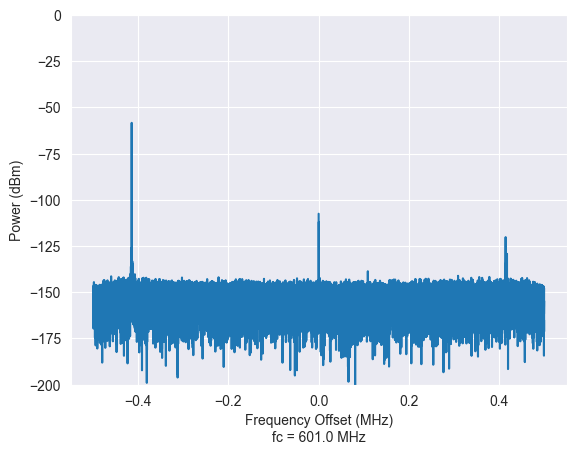

In [16]:
import numpy as np
from numpy.fft import fft, fftshift, fftfreq
import seaborn as sns
import matplotlib.pyplot as plt

centre_freq=centre_freq_MHz * 1e6
lna_en=True
fft_size = 65536        # Don't change
sample_rate = 122.88e6  # Don't change


# Step 6: view FFT
offset_dB = 171
if lna_en:
    offset_dB += 21

samples = np.fromfile(filename, dtype=np.int16, count=fft_size*2)
iq = (samples[::2] + 1j*samples[1::2])  # convert to IQIQIQ...
f=fft(iq*np.blackman(fft_size))
x=fftfreq(fft_size)
spec=20*np.log10(np.abs(f))-offset_dB

sns.set_style('darkgrid')
fig, ax = plt.subplots()
ax.plot(x, spec)
ax.grid(True)
ax.set_xlabel("Frequency Offset (MHz)\nfc = {} MHz".format(centre_freq/1e6))
ax.set_ylabel("Power (dBm)")
if lna_en:
    ax.set_ylim(-140, -40)
else:
    ax.set_ylim(-100, 0)
ax.set_ylim(-200,0)
plt.show()


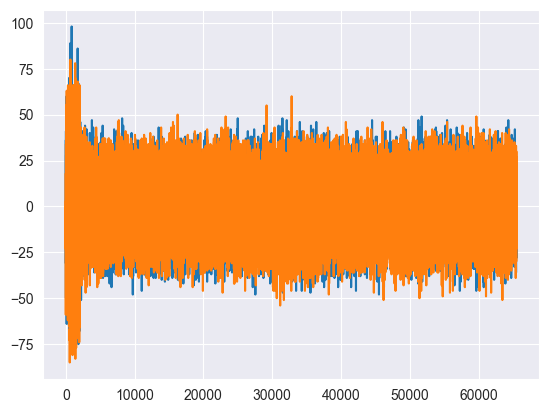

In [41]:
plt.plot(np.real(iq))
plt.plot(np.imag(iq))

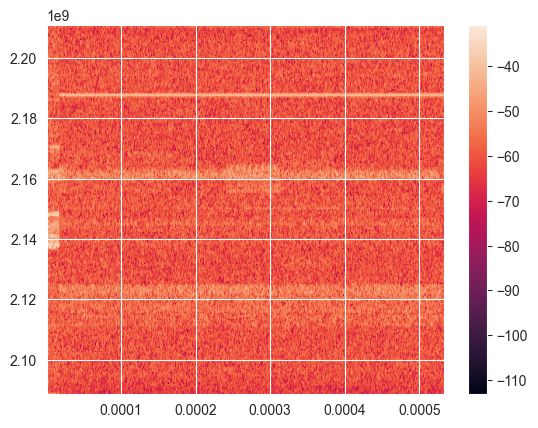

In [42]:
plt.specgram(iq, Fs=sample_rate, Fc=centre_freq, scale="dB")#, vmin=-210, vmax=-100)
plt.colorbar()
